In [82]:
import numpy as np
import xarray as xr
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from nearestPD import nearestPD
invm = np.linalg.inv


ds_2 = xr.open_dataset("data/regions_verify_202104_cov.nc")
bio_2 = ds_2["covariance_bio"]
anth_2 = ds_2["covariance_anth"]

M = bio_2
# determine threshold
thresh = 10**(-8)

# new thresholded matrix
M0 = np.where(abs(M) < thresh, 0, M)

# nearest non-singular to M0

#M0pd = nearestPD(M0)

#M0i = np.linalg.inv(M0)
# %timeit np.linalg.inv(M)



Visual check
* where the non-zero elements of the matrix are after setting the threshold
* nearest nonsingular 

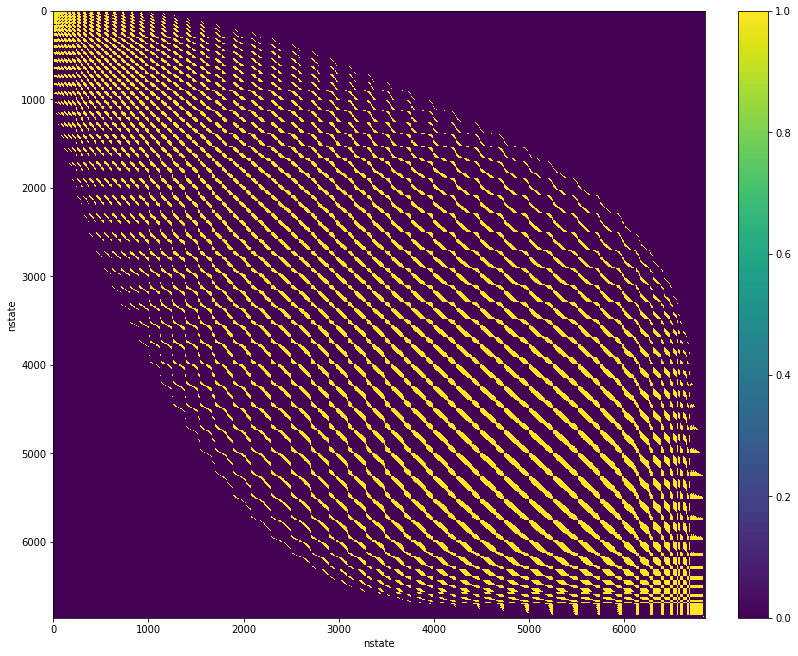

In [83]:



M0_binary = np.where(M0 != 0.0, 1.0, M0)
M0_binary = xr.DataArray(M0_binary)




fig, ax = plt.subplots(figsize = (11,9), layout= 'constrained')
M0_binary.plot.pcolormesh(yincrease = False)
ax.set_xlabel("nstate")
ax.set_ylabel("nstate")
plt.show()


#fig, ax = plt.subplots(layout = 'constrained')
#M0pd_binary.plot.pcolormesh(yincrease = False)





<xarray.DataArray ()>
array(0.) 0.0 0.24086587722293318 <xarray.DataArray ()>
array(0.8)


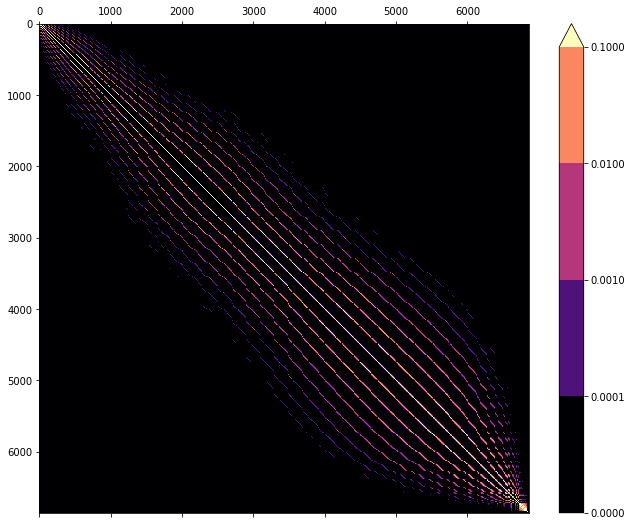

In [84]:
M0 = xr.DataArray(M0)
qlower = np.quantile(M0, 0.001)
qupper = np.quantile(M0, 0.999)
vmin = np.min(M0)
vmax = np.max(M0)
print(vmin, qlower, qupper, vmax)

fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([0., 1e-4, 1e-3, 1e-2, 1e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='max')
pcm = ax.matshow(M0, norm=norm, cmap='magma')
# The colorbar inherits the "extend" argument from BoundaryNorm.
fig.colorbar(pcm, ax=ax, orientation='vertical')
plt.show()

Yksinkertainen blokkijako
---------------------------

* Isommat blokit alakulmassa, koska siellä näyttäisi olevan leveämmällä "isoja" arvoja
* HUOM! get_blocks -funktion block-jakoa ei tällä hetkellä voi tehdä paralleelisti, koska seuraavan blockin alun saa edellisen silmukan sisällä. Pystyy varmasti helpohkosti muuttamaan tämän parallellisoitavaan muotoon
* Inversionin vois oikeestaan tehdä in-place ja samalla muuttaa nolliksi kaikki muut arvot
* Vai onko parempi koota uusi block_diag matriisi käännetyistä? (vrt. ei tarvitse ladata koko matriisia muistiin)

In [86]:
def get_blocks(M, nblock):
    """Partition the area around the diagonal of matrix M into nblock blocks of
    approximately equal size."""
    n = len(M)
    bsize = n//nblock
    nrem = n%nblock #remainder
    ls = []
    startb = 0 #index where the first block starts on the diagonal
    for i in np.arange(nblock):
        # nrow/ncol of the first nrem blocks is bsize+1
        if i < nblock - nrem:
            endb = startb+bsize #index for end of block
        else:
           endb = startb+bsize+1
        block = M[startb:endb, startb:endb]
        ls.append(block)
        startb = endb # the coordinate for the end of the block is the start of the new block
    return ls


def combine_inverted(blocks):
    for i in np.arange(len(blocks)):
        blocks[i] = invm(blocks[i])
    iM = scipy.linalg.block_diag(*blocks)
    return iM



Tests to see if functions work as intended
-------------------------------------------

In [89]:

nblocks = 2

testM = np.eye(9)*2
testblocks = get_blocks(testM, nblocks)
scipy.linalg.block_diag(*testblocks)
# for i in range(nblocks):
#     print(blocks[i])
#     print()


array([[2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 2.]])

In [90]:


itestM = combine_inverted(testblocks)
print(itestM)



[[0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5]]


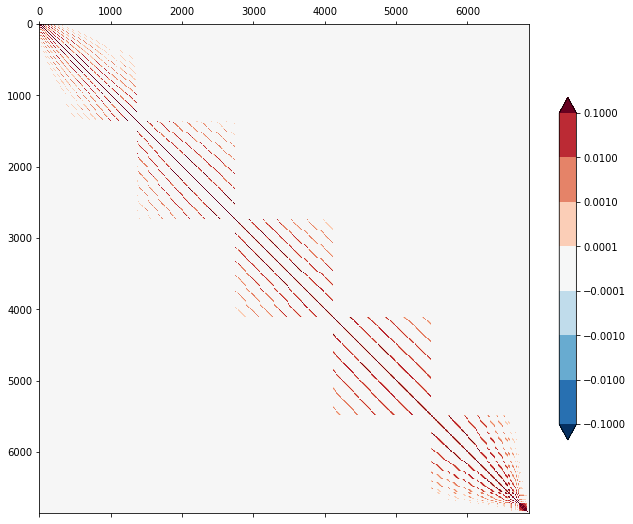

In [111]:
blocks = get_blocks(M.values,5)
M_block_diag = scipy.linalg.block_diag(*blocks)




fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([-1e-1 ,-1e-2,-1e-3,-1e-4, 1e-4, 1e-3, 1e-2, 1e-1])
#bounds = np.array([0., 1e-4, 1e-3, 1e-2, 1e-1, 0.8])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
pcm = ax.matshow(M_block_diag, norm=norm, cmap='RdBu_r')
# The colorbar inherits the "extend" argument from BoundaryNorm.
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink = 0.7)
plt.show()



In [112]:
iM_block_diag = combine_inverted(blocks)
iM = invm(M)

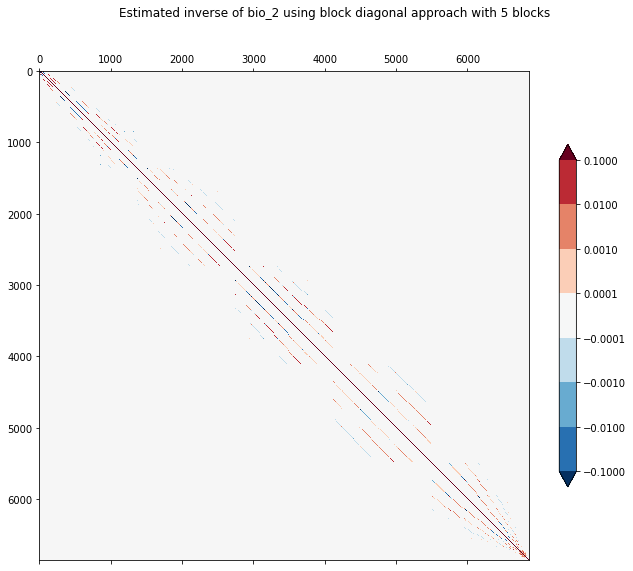

In [113]:



fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([-1e-1 ,-1e-2,-1e-3,-1e-4, 1e-4, 1e-3, 1e-2, 1e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
pcm = ax.matshow(iM_block_diag, norm=norm, cmap='RdBu_r')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink = 0.7)
fig.suptitle("Estimated inverse of bio_2 using block diagonal approach with 5 blocks")
plt.show()


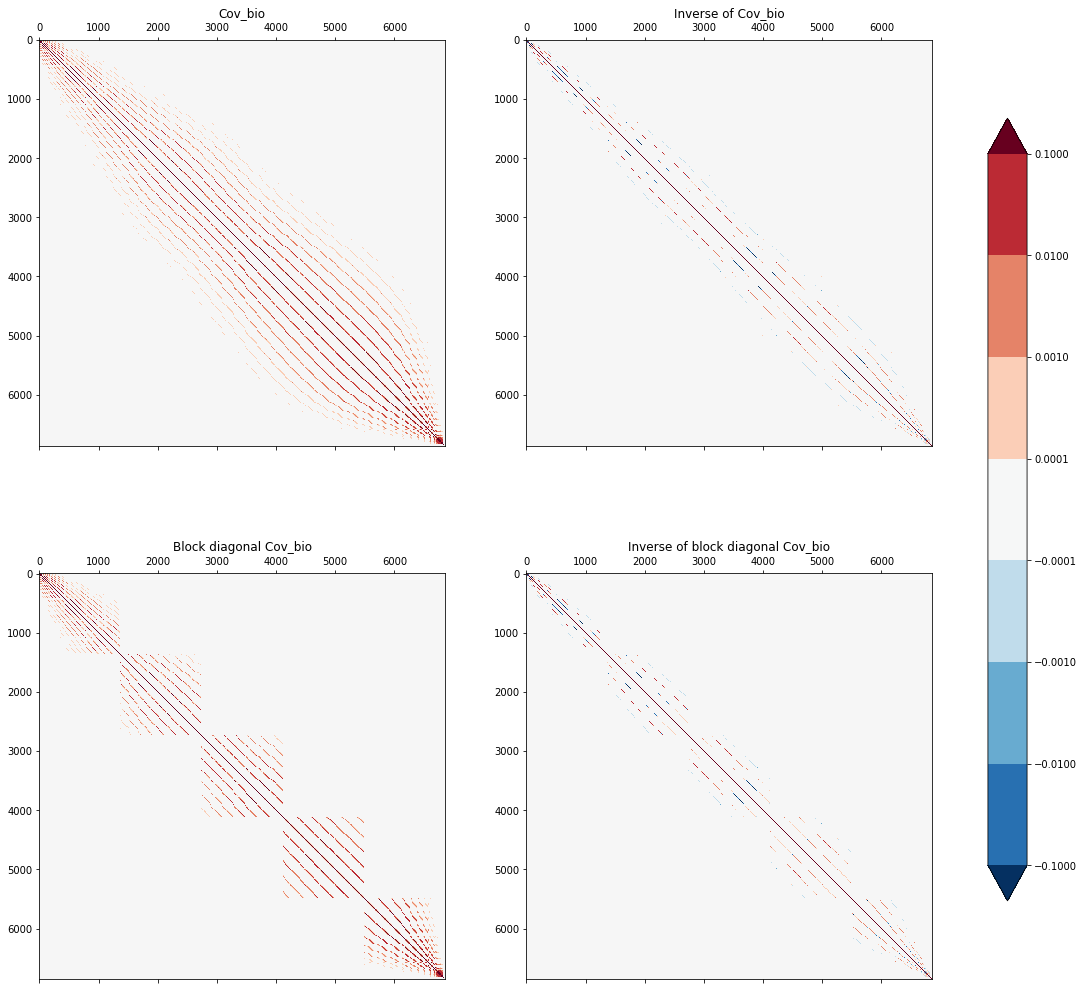

In [116]:
matrices = [M, iM, M_block_diag, iM_block_diag]
names = ["Cov_bio", "Inverse of Cov_bio", "Block diagonal Cov_bio", "Inverse of block diagonal Cov_bio"]

fig, axs = plt.subplots(2,2, figsize = (20,18))
bounds = np.array([-1e-1 ,-1e-2,-1e-3,-1e-4, 1e-4, 1e-3, 1e-2, 1e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
images = []
for k in range(4):
    i = k // 2
    j = k-2*i
    images.append(axs[i,j].matshow(matrices[k], cmap='RdBu_r'))
    axs[i,j].set_title(names[k])
for im in images:
    im.set_norm(norm)

fig.colorbar(im, ax=axs.ravel().tolist(), norm = norm, orientation = 'vertical', shrink = 0.8)
plt.show()

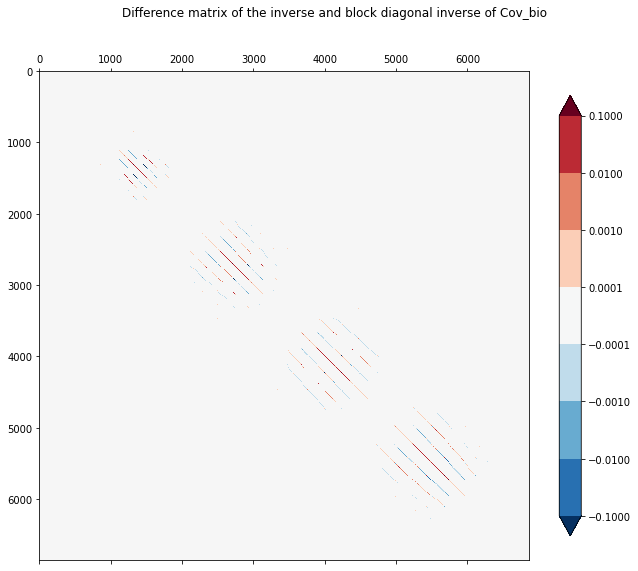

In [119]:


diff = iM-iM_block_diag

fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([-1e-1 ,-1e-2,-1e-3,-1e-4, 1e-4, 1e-3, 1e-2, 1e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
pcm = ax.matshow(diff, norm=norm, cmap='RdBu_r')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink = 0.9)
fig.suptitle("Difference matrix of the inverse and block diagonal inverse of Cov_bio")
plt.show()